# Software Engineer Technical Interview

## This interview process aims to assess a software engineer's skills in dealing with geospatial application problems. The candidate must provide the answers and code using an own public GitHub repository and a running Google Colab notebook.

##Task #1

Consider the following dataset to work with: https://www.kaggle.com/datasets/aman2000jaiswal/agriculture-crop-images. Provide a code for the items a-d bellow:

a. Create a model to classify with reasonable accuracy the images from the dataset base.

b. Save, in a non-relational database (e.g., MongoDB), the accuracy result for the training process.

c. Create a Python-based API (e.g., based on Flask, Streamlit) to receive an image from the user as input. After receiving the image, the API should call the trained model and return a response (including a JSON data) with accuracy metrics and classification (i.e., maize, wheat, jute, rice and sugarcane) according to the image provided.

d. Elaborate test cases for this implementation.

### a. Creating a model to classify images from the kaggle's agriculture crop images dataset

##### Setting up the environment for kaggle

In [ ]:
from google.colab import files

# To upload kaggle.json API token file
files.upload() 

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

##### Downloading the agricultural crop images dataset from kaggle

In [ ]:
import kaggle
kaggle.api.dataset_download_files('aman2000jaiswal/agriculture-crop-images', path='./', unzip=True)

##### Preprocessing data

In [ ]:
import pandas as pd

# Reading the dataset
data = pd.read_csv('./Crop_details.csv')

In [ ]:
data.head()

,Unnamed: 0,path,crop,croplabel
0,0,/kaggle/input/kag2/sugarcane/sugarcane037ahs.jpeg,sugarcane,3
1,1,/kaggle/input/kag2/sugarcane/sugarcane034a.jpeg,sugarcane,3
2,2,/kaggle/input/kag2/sugarcane/sugarcane032arot....,sugarcane,3
3,3,/kaggle/input/kag2/sugarcane/sugarcane036ahs.jpeg,sugarcane,3
4,4,/kaggle/input/kag2/sugarcane/sugarcane023ahs.jpeg,sugarcane,3


In [ ]:
# Data cleaning
data.drop('Unnamed: 0', axis=1)

# Converting croplabel to string
data['croplabel'] = data['croplabel'].astype(str)

# Reformatting image paths
data['path'] = data['path'].str.replace('/kaggle/input/', './')

##### Training the model

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Splitting the dataset into train and test sets (85% train, 15% test)
training_data, testing_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['croplabel'])

# Split the train_data into train and validation sets (80% train, 20% validation)
training_data, validation_data = train_test_split(training_data, test_size=0.2, random_state=42, stratify=training_data['croplabel'])

# Creating ImageDataGenerator instances for each set
training_data_generator = ImageDataGenerator(rescale=1./255)
validation_data_generator = ImageDataGenerator(rescale=1./255)
testing_data_generator = ImageDataGenerator(rescale=1./255)

# Defining parameters
target_size = (224, 224) 
batch_size = 32

# Creating generators for each set using the corresponding DataFrame
training_generator = training_data_generator.flow_from_dataframe(
    dataframe=training_data,
    x_col='path',
    y_col='croplabel',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=validation_data,
    x_col='path',
    y_col='croplabel',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

testing_generator = testing_data_generator.flow_from_dataframe(
    dataframe=testing_data,
    x_col='path',
    y_col='croplabel',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 679 validated image filenames belonging to 5 classes.
Found 170 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

# Loading the VGG16 pre-trained base model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# Fine-tuning the model
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(5, activation='softmax') # 5 classes
])

# Unfreezing the base model
base_model.trainable = True

# Using a smaller learning rate for fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

# Compiling the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
model.fit(training_generator, epochs=5, validation_data=validation_generator)

# Evaluating the model
test_loss, test_accuracy = model.evaluate(testing_generator)

# Printing test loss and test accuracy
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

Epoch 1/5
22/22 [==============================] - 15s 483ms/step - loss: 1.5883 - accuracy: 0.4757 - val_loss: 0.8266 - val_accuracy: 0.7176
Epoch 2/5
22/22 [==============================] - 10s 476ms/step - loss: 0.5505 - accuracy: 0.8395 - val_loss: 0.4328 - val_accuracy: 0.8000
Epoch 3/5
22/22 [==============================] - 11s 484ms/step - loss: 0.2500 - accuracy: 0.9323 - val_loss: 0.2446 - val_accuracy: 0.9059
Epoch 4/5
22/22 [==============================] - 10s 474ms/step - loss: 0.1093 - accuracy: 0.9823 - val_loss: 0.1751 - val_accuracy: 0.9412
Epoch 5/5
5/5 [==============================] - 1s 133ms/step - loss: 0.0798 - accuracy: 0.9933
Test loss: 0.07975013554096222, Test accuracy: 0.9933333396911621


In [ ]:
# Saving the model
model.save('agriculture_crop_images_model.h5')

### b. Saving the accuracy result of the training process in MongoDB

#### Downloading and installing a MongoDB Instance

In [ ]:
!pip install pymongo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 24.6 MB/s eta 0:00:00


In [ ]:
%%bash
sudo apt install -y mongodb
service mongodb start

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libpcap0.8 libyaml-cpp0.6 mongo-tools mongodb-clients mongodb-server
  mongodb-server-core
The following NEW packages will be installed:
  libpcap0.8 libyaml-cpp0.6 mongo-tools mongodb mongodb-clients mongodb-server
  mongodb-server-core
0 upgraded, 7 newly installed, 0 to remove and 24 not upgraded.
Need to get 55.8 MB of archives.
After this operation, 226 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libpcap0.8 amd64 1.9.1-3 [128 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libyaml-cpp0.6 amd64 0.6.2-4ubuntu1 [124 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 mongo-tools amd64 3.6.3-0ubuntu1 [12.3 MB]
Get:4 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 mongodb-clients amd64 1:3.6.9+really3.6.8+90~g8e540c0b6d-0ubuntu5.3 [21.6 MB]
Get:5 http://archive



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 7.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


#### Saving the accuracy result of the training process in the MongoDB Instance

In [ ]:
from pymongo import MongoClient

# Establish a connection to MongoDB
client = MongoClient()

# Create a database named "agriculture_classification"
db = client["agriculture_classification"]

# Create a collection named "training_results"
collection = db["training_results"]

# Prepare the data to be saved
data = {
    "model": "VGG16",
    "training_accuracy": test_accuracy,
}

# Insert the data into the collection
collection.insert_one(data)

### c. Creating a Python-based API using Flask to receive an image from the user as input

In [ ]:
!pip install Flask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import io
import json
import numpy as np
from PIL import Image
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

app = Flask(__name__)
model = load_model("agriculture_crop_images_model.h5")
class_labels = ["maize", "wheat", "jute", "rice", "sugarcane"]

def format_image(image, target_size=(224, 224)):
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = image.resize(target_size)
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

@app.route("/classify", methods=["POST"])
def classify_image():
    if "image" not in request.files:
        return jsonify({"error": "No image provided"}), 400

    image = request.files["image"].read()
    image = Image.open(io.BytesIO(image))
    image_array = format_image(image)

    predictions = model.predict(image_array)
    top_prediction = np.argmax(predictions)

    response = {
        "prediction": class_labels[top_prediction],
        "confidence": float(predictions[0][top_prediction])
    }

    return jsonify(response)

In [ ]:
app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


### d. Elaborating test cases

##### Testing the classification model

In [ ]:
from tensorflow.keras.models import load_model

# Loading the saved model
loaded_model = load_model('agriculture_crop_images_model.h5')

In [ ]:
import cv2
import os

def model_prediction(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224,224))
    image = image/255
    image = image.reshape(1,224,224,3)
    p = loaded_model.predict(image).argmax()
    return list({'jute': 0, 'maize': 1, 'rice': 2, 'sugarcane': 3, 'wheat': 4})[p]

path_test = './test_crop_image/'
file_names = os.listdir(path_test)
count = 0

for file in file_names:
    crops = model_prediction(path_test + file)

    # wheatcropfield04.jpg => wheat
    if file[:3] == crops[:3]:
        count += 1

print('Test_accuracy :', count/len(file_names))

1/1 [==============================] - 0s 22ms/step
Test_accuracy : 0.6274509803921569


##### Testing the MongoDB database

In [ ]:
import unittest

class TestMongoDB(unittest.TestCase):

    def setUp(self):
        connection_string = "mongodb://localhost:27017/"
        client = MongoClient(connection_string)
        self.db = client["agriculture_classification"]
        self.collection = self.db["training_results"]

    def test_insert_training_result(self):
        data = {
            "model": "TestModel",
            "test_accuracy": 0.789,
        }
        result = self.collection.insert_one(data)
        self.assertIsNotNone(result.inserted_id)
        inserted_document = self.collection.find_one({"_id": result.inserted_id})
        self.assertIsNotNone(inserted_document)
        self.collection.delete_one({"_id": result.inserted_id})

##### Testing the API

In [ ]:
import os
import requests
from pymongo import MongoClient

class TestAPI(unittest.TestCase):

    def setUp(self):
        self.url = "http://127.0.0.1:5000/classify"
        self.test_image_path = "/content/test_crop_image/jute-field.jpg"

    def test_classify_image(self):
        with open(self.test_image_path, "rb") as image_file:
            response = requests.post(self.url, files={"image": image_file})
        self.assertEqual(response.status_code, 200)
        json_response = response.json()
        self.assertIn("prediction", json_response)
        self.assertIn("confidence", json_response)

In [ ]:
# There would be an error with the TestAPI class since the Flask server isn't running
unittest.main(argv=[''], verbosity=2, exit=False)

test_classify_image (__main__.TestAPI) ... ERROR
test_insert_training_result (__main__.TestMongoDB) ... ok

ERROR: test_classify_image (__main__.TestAPI)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 95, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urllib3

##Task #2
Develop a Python class or function within Google Colab that seeks a geospatial tiff image as an input argument from the user. The class/function will take the geospatial raster data and apply Meta's [Segment Anything Model or SAM](https://github.com/facebookresearch/segment-anything) to segment agricultural fields from the image and saves the output as geospatial shapefile or geojson files. The skeleton of the class is given for you along with some hints.

#### Install Segment Anything Model (SAM), SAM's weights and other dependencies

In [1]:
# Installing Segment Anything
!pip install git+https://github.com/facebookresearch/segment-anything.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-hq8gq9ag
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-hq8gq9ag
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=87a10a5242f79bbf96d045e56b6e52c332258230958315bf246cc776d33c7b3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-szearfw5/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [2]:
# Downloading SAM weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [3]:
!pip install supervision rasterio geopandas shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 39.1 MB/s eta 0:00:00


#### SegmentBuildings class

In [10]:
import os
import torch
import rasterio
import supervision as sv
import numpy as np
import geopandas as gpd
import rasterio.features
from shapely.geometry import shape
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

class SegmentBuildings:
    def __init__(self, input_image_path, output_data_path):
        self.input_image_path = input_image_path
        self.output_data_path = output_data_path

    def main(self):
        # Use rasterio to read geospatial image
        with rasterio.open(self.input_image_path) as src:
            num_bands = src.count
            transform = src.transform
            crs = src.crs

            # Checking if the raster extracted has 3 bands (red, green, blue)
            # Some .tiff images (used in testing) didn't have 3 bands
            # They weren't able to be converted to rgb for SAM
            if num_bands >= 3:
              img = src.read()

        # Convert the geospatial image to a RGB image that SAM can understand
        def normalize_band(band):
            # Normalize function is used to rescale the data to the 0-255 range
            return ((band - band.min()) * (255 / (band.max() - band.min()))).astype(np.uint8)
        
        image_rgb = np.stack((normalize_band(img[0]), normalize_band(img[1]), normalize_band(img[2])), axis=2)

        # Apply SAM, using colab's GPU to reduce time
        # The SAM can be applied with either text prompt or other input args
        sam = sam_model_registry["vit_h"](checkpoint="/content/sam_vit_h_4b8939.pth").to(device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
        mask_generator = SamAutomaticMaskGenerator(sam)
        masks = mask_generator.generate(image_rgb)
        mask_annotator = sv.MaskAnnotator()

        detections = sv.Detections.from_sam(sam_result=masks)
        segmented_image = mask_annotator.annotate(scene=image_rgb.copy(), detections=detections)

        # For visualization, uncomment the line below
        sv.plot_images_grid(images=[image_rgb, segmented_image], grid_size=(1, 2), titles=['source image', 'segmented image'])

        # The output of SAM will lose the geospatial location information
        # Find out a way to retain back the location information from the given
        # raster. Hint: use the `transform`
        with rasterio.open(
            "segmented_image.tiff",
            "w",
            driver="GTiff",
            height=segmented_image.shape[1],
            width=segmented_image.shape[2],
            count=segmented_image.shape[0],
            dtype=segmented_image.dtype,
            crs=crs,
            transform=transform,
        ) as dst:
            dst.write(segmented_image)

        # Convert the segmented raster to a geojson or shapefile format based on the user-defined path
        with rasterio.open("/content/segmented_image.tiff") as src:
            segmented_data = src.read(1)

            # Extracting features (polygons) from the segmented raster
            features = rasterio.features.shapes(segmented_data, transform=src.transform, connectivity=4)

            # Converting features to Shapely geometries and create a GeoDataFrame
            polygons = []
            for geom, value in features:
                if value != 0:
                    polygon = shape(geom)
                    if polygon.area >= 0:
                        polygons.append(polygon)
            gdf = gpd.GeoDataFrame({"geometry": polygons, "id": range(len(polygons))}, crs=src.crs)

            # Saving the GeoDataFrame based on the file extension in the output_data_path
            file_extension = self.output_data_path.split('.')[-1].lower()
            if file_extension == "geojson":
                gdf.to_file(self.output_data_path, driver="GeoJSON")
            elif file_extension == "shp":
                gdf.to_file(self.output_data_path, driver="ESRI Shapefile")
            else:
                raise ValueError("Invalid file extension, must be '.geojson' or '.shp'")

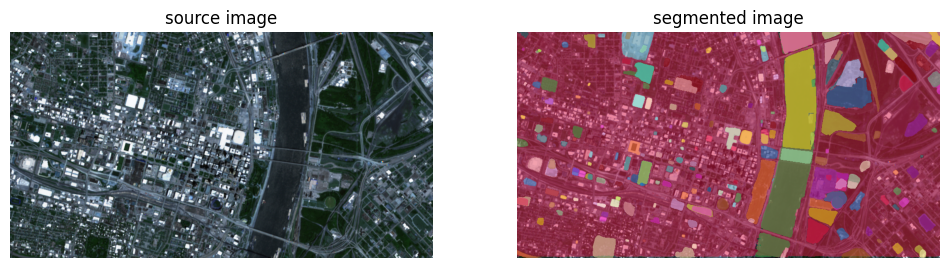

In [9]:
input_image_path = "./image.tiff"
output_data_path = "./segmented_image.geojson"
segment_buildings = SegmentBuildings(input_image_path, output_data_path)
segment_buildings.main()